In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Overview

TIn this tutorial, you learn about how to use text to speech, speech to text, blog creation, image generation using Chirp and Gemini 2.0

## Step 1: Transcribe and translate the voice recording  

#### Install Speech-to-Text SDK and other required packages


In [ ]:
! apt update -y -qq
! apt install ffmpeg -y -qq

41 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
%pip install --upgrade --quiet google-cloud-speech pydub etils jiwer ffmpeg-python plotly gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.4 MB/s eta 0:00:00


#### Authenticate your notebook environment (Colab only)

If you're running this notebook on Google Colab, run the cell below to authenticate your environment.

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

MessageError: Error: credential propagation was unsuccessful

#### Set Google Cloud project information and initialize Speech-to-Text V2 SDK

To get started using the Speech-to-Text API, you must have an existing Google Cloud project and [enable the Speech-to-Text API](https://console.cloud.google.com/flows/enableapi?apiid=speech.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
# Use the environment variable if the user doesn't provide Project ID.
import os

PROJECT_ID = "n25-vertex-ai-demos-1"  # @param {type: "string", placeholder: "[your-project-id]", isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

#### Import libraries

In [ ]:
!pip install gradio
!pip install google.cloud.speech
import io
import os

import IPython.display as ipd
from etils import epath as ep
from google.api_core.client_options import ClientOptions
from google.cloud.speech_v2 import SpeechClient
from google.cloud.speech_v2.types import cloud_speech
import gradio as gr
from pydub import AudioSegment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.0 MB/s eta 0:00:00


#### Set constants

In [ ]:
API_ENDPOINT = f"{LOCATION}-speech.googleapis.com"

client = SpeechClient(
    client_options=ClientOptions(
        api_endpoint=API_ENDPOINT,
    )
)

INPUT_AUDIO_SAMPLE_FILE_URI = (
    "gs://github-repo/audio_ai/speech_recognition/attention_is_all_you_need_podcast.wav"
)

RECOGNIZER = client.recognizer_path(PROJECT_ID, LOCATION, "_")

MAX_CHUNK_SIZE = 25600

#### Helpers

In [ ]:
def read_audio_file(audio_file_path: str) -> bytes:
    """
    Read audio file as bytes.
    """
    if audio_file_path.startswith("gs://"):
        with ep.Path(audio_file_path).open("rb") as f:
            audio_bytes = f.read()
    else:
        with open(audio_file_path, "rb") as f:
            audio_bytes = f.read()
    return audio_bytes


def save_audio_sample(audio_bytes: bytes, output_file_uri: str) -> None:
    """
    Save audio sample as a file in Google Cloud Storage.
    """

    output_file_path = ep.Path(output_file_uri)
    if not output_file_path.parent.exists():
        output_file_path.parent.mkdir(parents=True, exist_ok=True)

    with output_file_path.open("wb") as f:
        f.write(audio_bytes)


def extract_audio_sample(audio_bytes: bytes, duration: int) -> bytes:
    """
    Extracts a random audio sample of a given duration from an audio file.
    """
    audio = AudioSegment.from_file(io.BytesIO(audio_bytes))
    start_time = 0
    audio_sample = audio[start_time : start_time + duration * 1000]

    audio_bytes = io.BytesIO()
    audio_sample.export(audio_bytes, format="wav")
    audio_bytes.seek(0)

    return audio_bytes.read()


def play_audio_sample(audio_bytes: bytes) -> None:
    """
    Plays the audio sample in a notebook.
    """
    audio_file = io.BytesIO(audio_bytes)
    ipd.display(ipd.Audio(audio_file.read(), rate=44100))


def parse_real_time_recognize_response(
    response: cloud_speech.RecognizeResponse,
) -> list[tuple[str, int]]:
    """Parse real-time responses from the Speech-to-Text API"""
    real_time_recognize_results = []
    for result in response.results:
        real_time_recognize_results.append(
            (result.alternatives[0].transcript, result.result_end_offset)
        )
    return real_time_recognize_results


def parse_words_real_time_recognize_response(
    response: cloud_speech.RecognizeResponse,
) -> list[dict]:
    """
    Parse the word-level results from a real-time speech recognition response.
    """
    real_time_recognize_results = []
    for result in response.results:
        for word_info in result.alternatives[0].words:
            word = word_info.word
            start_time = word_info.start_offset.seconds
            end_time = word_info.end_offset.seconds
            real_time_recognize_results.append(
                {"word": word, "start": start_time, "end": end_time}
            )
    return real_time_recognize_results


def print_transcription(
    audio_sample_bytes: bytes, transcription: str, play_audio=True
) -> None:
    """Prettify the play of the audio and the associated print of the transcription text in a notebook"""

    if play_audio:
        # Play the audio sample
        display(ipd.HTML("<b>Audio:</b>"))
        play_audio_sample(audio_sample_bytes)
        display(ipd.HTML("<br>"))

    # Display the transcription text
    display(ipd.HTML("<b>Transcription:</b>"))
    formatted_text = f"<pre style='font-family: monospace; white-space: pre-wrap;'>{transcription}</pre>"
    display(ipd.HTML(formatted_text))

####Prepare audio samples

The podcast audio is ~ 8 mins. Depending on the audio length, you can use different transcribe API methods. To learn more, check out the official documentation.  

#### Read the audio file

Let's start reading the input audio sample you want to transcribe.

In this case, it is a podcast generated with NotebookLM about the "Attention is all you need" [paper](https://arxiv.org/abs/1706.03762).

In [ ]:
input_audio_bytes = read_audio_file(INPUT_AUDIO_SAMPLE_FILE_URI)

#### Prepare a short audio sample (< 1 min)

Extract a short audio sample from the original one for streaming and real-time audio processing.

In [ ]:
short_audio_sample_bytes = extract_audio_sample(input_audio_bytes, 30)

In [ ]:
play_audio_sample(short_audio_sample_bytes)

#### Define real-time recognition configuration with `enable_word_time_offsets` parameter.

You define the real-time recognition configuration which allows you to set the model to use, language code of the audio and more.

In this case, you enable word timing feature. When True, the top result includes a list of words and the start and end time offsets (timestamps) for those words.

In [ ]:
wt_real_time_config = cloud_speech.RecognitionConfig(
    auto_decoding_config=cloud_speech.AutoDetectDecodingConfig(),
    language_codes=["en-US"],
    model="chirp_2",
    features=cloud_speech.RecognitionFeatures(
        enable_word_time_offsets=True,
        enable_automatic_punctuation=True,
    ),
)

#### Define the real-time request configuration

Next, you define the real-time request passing the configuration and the audio sample you want to transcribe.


In [ ]:
wt_real_time_request = cloud_speech.RecognizeRequest(
    config=wt_real_time_config, content=short_audio_sample_bytes, recognizer=RECOGNIZER
)

### 1-1 Run the real-time recognition request

Finally you submit the real-time recognition request.

In [ ]:
wt_response = client.recognize(request=wt_real_time_request)
wt_real_time_recognize_results = parse_real_time_recognize_response(wt_response)

And you use a helper function to visualize transcriptions and the associated streams.

In [ ]:
for transcription, _ in wt_real_time_recognize_results:
    print_transcription(short_audio_sample_bytes, transcription)

#### Define real-time recognition configuration with `adaptation` parameter

You define a new real-time recognition configuration which includes the `adaptation` configuration.


In [ ]:
adaptation_real_time_config = cloud_speech.RecognitionConfig(
    auto_decoding_config=cloud_speech.AutoDetectDecodingConfig(),
    language_codes=["en-US"],
    model="chirp_2",
    features=cloud_speech.RecognitionFeatures(
        enable_automatic_punctuation=True,
    ),
    adaptation=cloud_speech.SpeechAdaptation(
        phrase_sets=[
            cloud_speech.SpeechAdaptation.AdaptationPhraseSet(
                inline_phrase_set=cloud_speech.PhraseSet(
                    phrases=[
                        cloud_speech.PhraseSet.Phrase(
                            value="you know",  # often mumbled or spoken quickly
                            boost=10.0,
                        ),
                        cloud_speech.PhraseSet.Phrase(
                            value="what are they called again?",  # hesitations and changes in intonation
                        ),
                        cloud_speech.PhraseSet.Phrase(
                            value="Yeah, it's wild.",  # short interjections have brevity and the emotional inflection
                        ),
                    ]
                )
            )
        ]
    ),
)

###1-1 Run the real-time recognition request

In [ ]:
adapted_response = client.recognize(
    request=cloud_speech.RecognizeRequest(
        config=adaptation_real_time_config,
        content=short_audio_sample_bytes,
        recognizer=RECOGNIZER,
    )
)
adapted_real_time_recognize_results = parse_real_time_recognize_response(
    adapted_response
)

And you use a helper function to visualize transcriptions and the associated streams.

In [ ]:
for transcription, _ in adapted_real_time_recognize_results:
    print_transcription(short_audio_sample_bytes, transcription)

### 1-2 Transcript and translate using language-agnostic transcription and language translation

Chirp 2 supports language-agnostic audio transcription and language translation. This means that Chirp 2 is capable of recognizing the language of the input audio and, at the same time, translate the outcome transcription in many different language.


#### Define real-time recognition configuration with `language_code` and `translationConfig` parameters.

You define a real-time recognition configuration by setting language codes in both `language_codes` and `translationConfig` parameters :

*   When `language_codes=["auto"]`, you enable language-agnostic transcription to auto to detect language.

*  When `target_language=language_code` where `language_code` is one of the language in this list but different from the original language, you enable language translation.

In [ ]:
target_language_code = "ja-JP"  # @param {type:"string", isTemplate: true}

#### Define the real-time request configuration

In [ ]:
ts_real_time_request = cloud_speech.RecognizeRequest(
    config=cloud_speech.RecognitionConfig(
        auto_decoding_config=cloud_speech.AutoDetectDecodingConfig(),
        language_codes=["en-US"],
        translation_config=cloud_speech.TranslationConfig(
            target_language=target_language_code
        ),
        model="chirp_2",
        features=cloud_speech.RecognitionFeatures(
            enable_automatic_punctuation=True,
        ),
    ),
    content=short_audio_sample_bytes,
    recognizer=RECOGNIZER,
)

#### Run the real-time recognition request

In [ ]:
ts_response = client.recognize(request=ts_real_time_request)
ts_real_time_recognize_results = parse_real_time_recognize_response(ts_response)

And you use a helper function to visualize transcriptions and the associated streams.

In [ ]:
for transcription, _ in ts_real_time_recognize_results:
    print_transcription(short_audio_sample_bytes, transcription, play_audio=False)

## Step 2. Generate blogpost and image using Gemini Multimodal  

In [ ]:
%pip install --upgrade --quiet google-genai

#### Authenticate

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

#### Import Library

In [ ]:
from IPython.display import HTML, Markdown, display
from google import genai
from google.genai.types import (
    FunctionDeclaration,
    GenerateContentConfig,
    GoogleSearch,
    HarmBlockThreshold,
    HarmCategory,
    MediaResolution,
    Part,
    Retrieval,
    SafetySetting,
    Tool,
    ToolCodeExecution,
    VertexAISearch,
)

In [ ]:
import os

PROJECT_ID = "yan-sbot"  # @param {type: "string", placeholder: "[your-project-id]", isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

LOCATION = os.environ.get("GOOGLE_CLOUD_REGION", "us-central1")

client = genai.Client(vertexai=True, project=PROJECT_ID, location=LOCATION)

In [ ]:
MODEL_ID = "gemini-2.0-flash"  # @param {type: "string"}

In [ ]:
chat = client.chats.create(model=MODEL_ID)

### 2-1 Generate blog post based on the recording

In [ ]:
from google.colab import files
response = chat.send_message("Write a blog post based on the description 'Okay, so you know, everyone's been talking about AI lately, right? Writing poems, like nailing those tricky emails, even building websites and all you need is a few, what are they called again? Prompts? Yeah, it's wild. These AI tools are suddenly everywhere. It's hard to keep up. Seriously. But here's the thing, a lot of this AI stuff we're seeing, it all goes back to this one research paper from way back in 2017. Attention is all you need. So today we're doing a deep dive into the core of it, the engine that's kind of driving'",
)

display(Markdown(response.text))

###Now response is defined in current scope
# Create a file-like object in memory
f = io.StringIO()

# Write the output of the Gemini blog post to the file-like object
print(response.text, file=f)

# Reset the file pointer to the beginning of the file
f.seek(0)

# First, write the contents of the StringIO object to a file
with open('blog_post.txt', 'w') as outfile:
    outfile.write(f.read())

# Now, you can download the file from the disk
files.download('blog_post.txt')

## Attention! The Secret Sauce Behind All That AI Magic

Okay, so you know, everyone's been talking about AI lately, right? Writing poems, like nailing those tricky emails, even building websites and all you need is a few, what are they called again? Prompts? Yeah, it's wild. These AI tools are suddenly everywhere. It's hard to keep up. Seriously.

You're scrolling through Twitter and boom, an AI generated image that's indistinguishable from a photograph. You're drafting an email and suddenly the AI assistant is finishing your sentences for you. It's both fascinating and a little… unsettling.

But here's the thing: a lot of this AI stuff we're seeing, from ChatGPT to Stable Diffusion, goes back to this one research paper from way back in 2017. A paper so fundamental that it revolutionized the field of natural language processing (NLP) and paved the way for the AI boom we're experiencing today.

That paper? **"Attention is All You Need."**

So today, we're doing a deep dive into the core of it, the engine that's kind of driving, well, everything. We're going to try and demystify the magic and understand why this "attention" thing is such a big deal.

**The Problem with Old School NLP**

Before 2017, Natural Language Processing relied heavily on Recurrent Neural Networks (RNNs) and their more sophisticated cousins, LSTMs (Long Short-Term Memory). These models were designed to process sequential data, like words in a sentence, one after the other.

Imagine reading a book. You read each word in order, building an understanding of the sentence and then the paragraph. RNNs and LSTMs did something similar.

The problem? **Sequential processing is slow.** Training these models on massive datasets took forever. More importantly, they struggled with long-range dependencies. In a long sentence, remembering the context from the beginning could be difficult, leading to inaccuracies.

Think about this sentence: "The dog, who was brown and fluffy and liked to chase squirrels in the park, jumped over the fence."  Understanding that the subject of the sentence is "dog" requires remembering that word even after wading through a bunch of descriptive phrases. RNNs often struggled to make that connection.

**Enter: Attention is All You Need**

The "Attention is All You Need" paper proposed a radical new architecture called the **Transformer**.  The key innovation was the **attention mechanism**.

So, what is attention?

Imagine reading the same sentence about the dog. Instead of focusing on each word in order, your brain consciously decides which parts of the sentence are most important for understanding the current word. When reading "jumped," you might focus more on "dog" to understand who is doing the jumping.

The attention mechanism does something similar. **For each word in the input, it calculates a score representing its relevance to other words in the sentence.** These scores are then used to weight the importance of each word when processing the current word.

**Think of it as a popularity contest amongst words.** Each word gets to "vote" for the other words it thinks are most relevant. The words with the most votes get more attention!

**Why is this so revolutionary?**

*   **Parallel Processing:** The attention mechanism allows the model to process all words in the input simultaneously, unlike sequential RNNs. This leads to significantly faster training and inference times.
*   **Long-Range Dependencies:** The attention mechanism allows the model to directly connect words that are far apart in the sentence, overcoming the limitations of RNNs.  Remember the dog? The Transformer can easily connect "dog" and "jumped" regardless of the intervening phrases.
*   **Interpretability:** The attention scores provide insights into which words the model is focusing on when making predictions. This can help us understand how the model is "thinking" and identify potential biases.

**The Legacy of Attention**

The "Attention is All You Need" paper sparked a revolution in NLP and beyond. The Transformer architecture, powered by the attention mechanism, has become the foundation for countless state-of-the-art models, including:

*   **BERT:** Google's Bidirectional Encoder Representations from Transformers, which revolutionized search.
*   **GPT-3 & ChatGPT:** OpenAI's Generative Pre-trained Transformer, capable of generating human-quality text, translating languages, and more.
*   **Stable Diffusion & DALL-E 2:** Image generation models that can create stunning visuals from text descriptions.

**So, the next time you're amazed by an AI tool, remember "Attention is All You Need." It's the deceptively simple idea that's powering the future of AI.**

**Further Reading (If you're feeling brave):**

*   The original "Attention is All You Need" paper: [https://arxiv.org/abs/1706.03762](https://arxiv.org/abs/1706.03762)
*   An Illustrated Transformer: [http://jalammar.github.io/illustrated-transformer/](http://jalammar.github.io/illustrated-transformer/)

What are your thoughts on the Transformer architecture and its impact on AI? Let us know in the comments below!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# --- Prerequisites ---
# Use fpdf2 - the maintained successor library, ensure latest version
!pip install -U fpdf2
# Remove pypdf2 install unless you specifically need it for reading PDFs elsewhere
# !pip install pypdf2 # Likely not needed for *creating* this PDF

# --- Imports ---
from google.colab import files
# import PyPDF2 as pypdf2 # Likely not needed
from fpdf import FPDF # fpdf2 uses the same import name
import os
import traceback # For more detailed error reporting if needed

# --- Configuration ---
TEXT_FILE_PATH = 'blog_post.txt'
OUTPUT_PDF_PATH = 'blog_post_wrapped_v4.pdf' # Using a new name

# Use a core PDF font directly to avoid substitution warning
FONT_FAMILY = "Helvetica" # Changed from "Arial"
FONT_SIZE = 11
# Define line height in mm. Adjust based on FONT_SIZE and desired spacing.
EFFECTIVE_LINE_HEIGHT = 6 # Increased slightly, 5mm can be tight for 11pt

# --- PDF Generation ---
print("Initializing PDF...")
# Consider specifying page format explicitly (optional, default is A4)
# pdf = FPDF(format='letter')
pdf = FPDF()
pdf.add_page()

# --- Calculate available width ---
# Still useful for the long word check
page_width = pdf.w # Total page width
left_margin = pdf.l_margin
right_margin = pdf.r_margin
available_width = page_width - left_margin - right_margin
print(f"DEBUG: Page Width={page_width:.2f}mm, LMargin={left_margin:.2f}mm, RMargin={right_margin:.2f}mm, AvailableWidth={available_width:.2f}mm")
# Basic check to prevent errors if margins are somehow misconfigured
if available_width <= 1: # Need at least some space
    raise ValueError(f"Calculated available page width ({available_width:.2f}mm) is too small. Check page margins, size, and orientation.")

# Set the font (using the corrected family name)
print(f"Setting font to '{FONT_FAMILY}' size {FONT_SIZE}")
pdf.set_font(FONT_FAMILY, size=FONT_SIZE)

# --- Process File and Add to PDF ---
print(f"\nProcessing text file: {TEXT_FILE_PATH}...")
line_number = 0
try:
    # Open the text file using UTF-8 encoding
    with open(TEXT_FILE_PATH, 'r', encoding='utf-8') as text_file:
        # Read the text file line by line
        for line in text_file:
            line_number += 1
            processed_line = line.rstrip('\n')
            # Simple check for blank lines from input
            is_blank_line = not processed_line.strip()
            print(f"DEBUG Line {line_number}: Processing text -> '{processed_line[:100]}...'") # Show first 100 chars

            # --- Add check and fix for long words (keep this safeguard) ---
            words = processed_line.split(' ')
            safe_words = []
            for word in words:
                if not word: continue # Skip empty strings
                try:
                    word_width = pdf.get_string_width(word)
                    if word_width > available_width:
                        print(f"WARNING: Word too long on Line {line_number}. Truncating word starting with: '{word[:30]}...'")
                        fitting_chars = 0
                        for i in range(1, len(word) + 1):
                            if pdf.get_string_width(word[:i]) > available_width:
                                fitting_chars = max(0, i - 1)
                                break
                        else: fitting_chars = len(word) if pdf.get_string_width(word) <= available_width else 0

                        if fitting_chars > 3 : truncated_word = word[:fitting_chars - 3] + "..."
                        elif fitting_chars > 0: truncated_word = word[:fitting_chars] + ".." if fitting_chars > 1 else word[:fitting_chars] + "."
                        else: truncated_word = "[X]"
                        safe_words.append(truncated_word)
                    else:
                        safe_words.append(word)
                except Exception as width_calc_error:
                     print(f"WARNING: Could not calculate width for word on line {line_number}: '{word[:30]}...'. Error: {width_calc_error}. Replacing word.")
                     safe_words.append("[ERR_WIDTH]")
                     continue
            final_line_to_print = " ".join(safe_words)
            # End of check ---

            # --- Use write() instead of multi_cell() ---
            if not is_blank_line:
                 pdf.write(h=EFFECTIVE_LINE_HEIGHT, text=final_line_to_print)

            # --- Add a line break to simulate the newline from the input file ---
            # This moves to the beginning of the next line.
            # Adjust height if spacing needs modification.
            pdf.ln(EFFECTIVE_LINE_HEIGHT)


    print(f"\nFinished processing file ({line_number} lines).")

# --- Save and Download the PDF ---
except FileNotFoundError:
    print(f"ERROR: The input file '{TEXT_FILE_PATH}' was not found.")
except Exception as e:
    # Catch errors during processing or PDF generation
    print(f"\nERROR occurred on or after processing Line {line_number}:")
    print(f"An error occurred during file processing or PDF generation: {e}")
    print("\n--- Traceback ---")
    traceback.print_exc() # Print detailed traceback
    print("--- End Traceback ---")
    # Optional: Print the potentially problematic line parts for review
    if 'processed_line' in locals():
       print(f"Original line content (approx): '{processed_line[:200]}...'")
    if 'final_line_to_print' in locals():
       print(f"Processed line content (approx): '{final_line_to_print[:200]}...'")

else: # This block runs if the 'try' block (processing file) completed without errors
    try:
        print(f"\nSaving PDF to: {OUTPUT_PDF_PATH}...")
        pdf.output(OUTPUT_PDF_PATH) # Just provide the filename to save
        print("PDF saved successfully.")

        # --- Download the PDF file (for Google Colab environment) ---
        try:
            print("Attempting to initiate download (Colab)...")
            files.download(OUTPUT_PDF_PATH)
            print(f"Download initiated for {OUTPUT_PDF_PATH}.")
        except NameError:
            print(f"Skipping automatic download (not in Colab environment). PDF is saved at: {os.path.abspath(OUTPUT_PDF_PATH)}")
        except Exception as download_error:
            print(f"An error occurred during file download: {download_error}")

    except Exception as save_error:
        print(f"An error occurred while saving the PDF: {save_error}")

Initializing PDF...
DEBUG: Page Width=210.00mm, LMargin=10.00mm, RMargin=10.00mm, AvailableWidth=190.00mm
Setting font to 'Helvetica' size 11

Processing text file: blog_post.txt...
DEBUG Line 1: Processing text -> '## Attention! The Secret Sauce Behind All That AI Magic...'
DEBUG Line 2: Processing text -> '...'
DEBUG Line 3: Processing text -> 'Okay, so you know, everyone's been talking about AI lately, right? Writing poems, like nailing those...'
DEBUG Line 4: Processing text -> '...'
DEBUG Line 5: Processing text -> 'You're scrolling through Twitter and boom, an AI generated image that's indistinguishable from a pho...'
DEBUG Line 6: Processing text -> '...'
DEBUG Line 7: Processing text -> 'But here's the thing: a lot of this AI stuff we're seeing, from ChatGPT to Stable Diffusion, goes ba...'
DEBUG Line 8: Processing text -> '...'
DEBUG Line 9: Processing text -> 'That paper? **"Attention is All You Need."**...'
DEBUG Line 10: Processing text -> '...'
DEBUG Line 11: Processing te

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for blog_post_wrapped_v4.pdf.


### 2-2 Generate image and text as blogpost cover

In [ ]:
from IPython.display import Image, Markdown, display

# import the Google Gen AI SDK
from google.genai.types import GenerateContentConfig, Part

In [ ]:
MODEL_ID = "gemini-2.0-flash-exp"  # @param {type: "string"}

In [ ]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents="generate an image based on the description 'The AI Revolution: It All Started With...Attention?'",
    config=GenerateContentConfig(
        response_modalities=["TEXT", "IMAGE"],
    ),
)




#### Download the blogpost cover page as blogpost_cover.png

Processing model response...

--- Image Part ---
Displaying image via IPython:


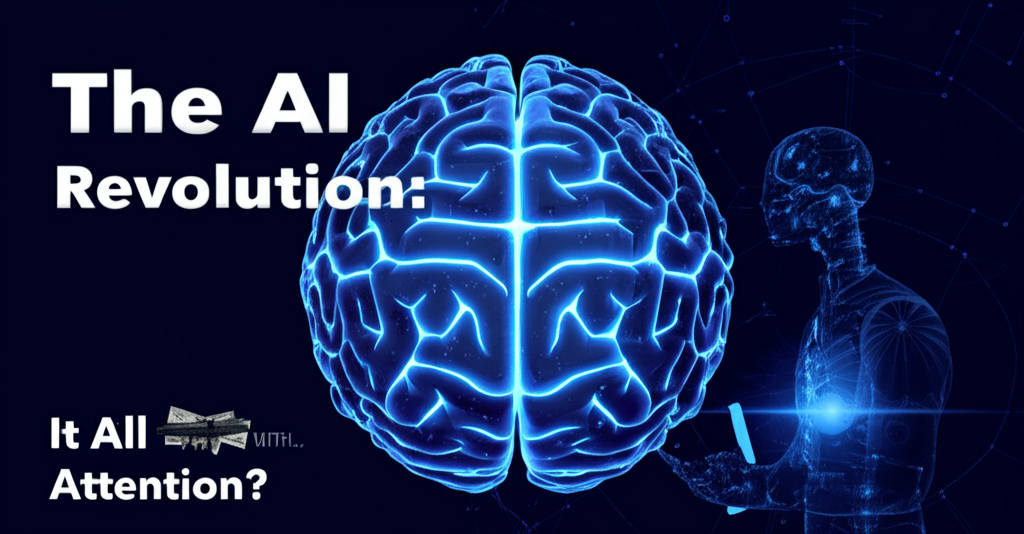


Saving image data to temporary file: blogpost_cover.png...
Temporary image file saved successfully.
Attempting to open image file: blogpost_cover.png
Image opened successfully (1024x534 pixels). Mode: RGB
Creating PDF: blogpost_cover.pdf...
Adding image to PDF at (10.00, 98.96) with size (190.00 x 99.08) mm
PDF successfully saved locally as blogpost_cover.pdf
Attempting file download (Colab environment detected)...


<ipython-input-62-a3c68d70afb4>:79: DeprecationWarning: "dest" parameter is deprecated since v2.2.0, unused and will soon be removed
  pdf.output(pdf_filepath, "F")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Colab download initiated for blogpost_cover.pdf.
Removing temporary file: blogpost_cover.png


In [ ]:
# !pip install Pillow fpdf google-generativeai ipython # Add others if needed

# --- Imports ---
from IPython.display import Image as IPyImage, Markdown, display # Renamed for clarity
# from google.genai.types import GenerateContentConfig, Part # Assuming these are used for 'response'
from fpdf import FPDF
from PIL import Image as PILImage # <--- Import Image from Pillow as PILImage
import os

# Import 'files' module only if in Google Colab
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
import traceback # For detailed error printing

# --- Function to Convert PNG to PDF ---
def convert_png_to_pdf_and_download(png_filepath, pdf_filepath):
    """
    Opens a PNG image file, creates a PDF with the image centered,
    saves the PDF, and initiates download if in Colab.
    Handles RGBA PNGs by converting them to RGB with a white background.
    """
    try:
        print(f"Attempting to open image file: {png_filepath}")
        # Use PILImage.open (from Pillow) to open the image file
        img = PILImage.open(png_filepath)
        width_px, height_px = img.size
        print(f"Image opened successfully ({width_px}x{height_px} pixels). Mode: {img.mode}")

        # --- Handle RGBA images ---
        # FPDF has issues with transparency, convert RGBA to RGB on a white background
        if img.mode == 'RGBA' or 'A' in img.mode:
            print("Image has alpha channel (transparency), converting to RGB...")
            # Create a new white background image of the same size
            background = PILImage.new('RGB', img.size, (255, 255, 255))
            # Try to get alpha channel, paste using it as mask if available
            alpha_channel = None
            if 'A' in img.getbands():
                alpha_channel = img.split()[-1]

            if alpha_channel:
                 background.paste(img, mask=alpha_channel)
            else: # Fallback if alpha channel not found despite mode
                 background.paste(img)
            img = background # Use the flattened image
            print("Converted RGBA image to RGB.")

        # --- Prepare PDF ---
        # PDF page dimensions (A4: 210x297 mm)
        pdf_page_width = 210
        pdf_page_height = 297
        margin = 10 # mm

        # Calculate available space for the image
        max_width_mm = pdf_page_width - 2 * margin
        max_height_mm = pdf_page_height - 2 * margin

        # Calculate scaling factor to fit image within margins
        scale_factor = min(max_width_mm / width_px, max_height_mm / height_px)
        image_width_mm = width_px * scale_factor
        image_height_mm = height_px * scale_factor

        # Calculate position to center the image on the page
        x_pos = (pdf_page_width - image_width_mm) / 2
        y_pos = (pdf_page_height - image_height_mm) / 2 # Center vertically too

        print(f"Creating PDF: {pdf_filepath}...")
        pdf = FPDF(orientation='P', unit='mm', format='A4')
        pdf.add_page()

        # Add the image to the PDF using its file path
        # FPDF uses the file path, it doesn't need the PILImage object directly after opening
        print(f"Adding image to PDF at ({x_pos:.2f}, {y_pos:.2f}) with size ({image_width_mm:.2f} x {image_height_mm:.2f}) mm")
        pdf.image(png_filepath, x=x_pos, y=y_pos, w=image_width_mm, h=image_height_mm)

        # Save the PDF
        pdf.output(pdf_filepath, "F")
        print(f"PDF successfully saved locally as {pdf_filepath}")

        # Download in Colab environment
        if IN_COLAB:
            try:
                print("Attempting file download (Colab environment detected)...")
                files.download(pdf_filepath)
                print(f"Colab download initiated for {pdf_filepath}.")
            except Exception as download_error:
                print(f"Colab download failed: {download_error}")
        else:
            print(f"PDF is available at: {os.path.abspath(pdf_filepath)}")

    except FileNotFoundError:
         print(f"Error: The image file was not found at '{png_filepath}'.")
    except Exception as e:
        print(f"\n--- An Error Occurred in convert_png_to_pdf_and_download ---")
        print(f"Error: {e}")
        print(traceback.format_exc()) # Print detailed traceback for debugging

# --- Main Logic ---
try:
    # --- Assume 'response' is the result from client.models.generate_content ---
    # [ ... Your code to get the 'response' object ... ]
    # Example placeholder:
    # response = client.models.generate_content(...) # Make sure this runs first

    print("Processing model response...")
    image_data = None
    # Safely extract image data and display parts
    if hasattr(response, 'candidates') and response.candidates:
         if hasattr(response.candidates[0], 'content') and response.candidates[0].content:
             if hasattr(response.candidates[0].content, 'parts') and response.candidates[0].content.parts:
                 for part in response.candidates[0].content.parts:
                     # Display text if present
                     if hasattr(part, 'text') and part.text:
                         print("\n--- Text Part ---")
                         display(Markdown(part.text))
                     # Find, store, and display image data
                     if hasattr(part, 'inline_data') and part.inline_data and hasattr(part.inline_data, 'data'):
                          mime_type = getattr(part.inline_data, 'mime_type', 'image/') # Check mime type if available
                          if mime_type.startswith('image/'):
                             print("\n--- Image Part ---")
                             image_data = part.inline_data.data
                             print("Displaying image via IPython:")
                             # Use IPyImage (from IPython.display) for display
                             ipy_image = IPyImage(data=image_data)
                             display(ipy_image)
                             # Assuming we only need the first image found
                             break
             else:
                 print("Info: Response content has no 'parts'.")
         else:
             print("Info: Response candidate has no 'content'.")
    else:
         print("Info: Response has no 'candidates'.")

    # --- Save Image and Convert to PDF ---
    if image_data:
        # Define output filenames
        output_png_filename = "blogpost_cover.png" # Correct filename, no double extension
        output_pdf_filename = "blogpost_cover.pdf"

        print(f"\nSaving image data to temporary file: {output_png_filename}...")
        try:
            # Save the raw image bytes received from the API to a file
            with open(output_png_filename, "wb") as f:
                f.write(image_data)
            print("Temporary image file saved successfully.")

            # Call the conversion function using the saved PNG file
            convert_png_to_pdf_and_download(output_png_filename, output_pdf_filename)

            # Optional: Clean up the temporary PNG file after conversion
            try:
                print(f"Removing temporary file: {output_png_filename}")
                os.remove(output_png_filename)
            except OSError as oe:
                print(f"Warning: Could not remove temporary file {output_png_filename}: {oe}")

        except IOError as e:
            print(f"Error saving image file '{output_png_filename}': {e}")
            print(traceback.format_exc())
    else:
        print("\nNo image data found in the response to process into a PDF.")

except NameError as ne:
     print(f"\n--- An Error Occurred (Setup Issue) ---")
     print(f"Error: A required variable (like 'response' or 'client') might not be defined.")
     print(ne)
     print(traceback.format_exc())
except Exception as e:
    print(f"\n--- An Unexpected Error Occurred in Main Logic ---")
    print(f"Error: {e}")
    print(traceback.format_exc())

### 2-3 Combine blogpost and blogpost cover

In [ ]:
!pip install PyPDF2
import PyPDF2

def combine_pdfs(cover_pdf, content_pdf, output_pdf):
    try:
        pdf_merger = PyPDF2.PdfMerger()

        # Open the cover PDF
        with open(cover_pdf, 'rb') as cover_file:
            pdf_merger.append(cover_file)

        # Open the content PDF
        with open(content_pdf, 'rb') as content_file:
            pdf_merger.append(content_file)

        # Write the merged PDF to a new file
        with open(output_pdf, 'wb') as output_file:
            pdf_merger.write(output_file)

        print(f"PDFs merged successfully! Output file: {output_pdf}")
    except FileNotFoundError:
        print(f"Error: One or both of the input PDF files were not found.")
    except Exception as e:
        print(f"An error occurred during PDF merging: {e}")

# Example usage
# Ensure 'blog_post_wrapped.pdf' exists; it was previously 'blog_post_wrapped_v4.pdf'
combine_pdfs('blogpost_cover.pdf', 'blog_post_wrapped_v4.pdf', 'combined_blogpost.pdf')

# Download the combined PDF (for Google Colab)
from google.colab import files
try:
  files.download('combined_blogpost.pdf')
except NameError:
  print("Files module not available, likely not running in Colab.")

PDFs merged successfully! Output file: combined_blogpost.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.cloud import storage

def upload_blob(cloud_next_demo, output_pdf, destination_blob_name):
    """Uploads a file to the bucket."""
    # The ID of your GCS bucket
    bucket_name = "cloud_next_demo"  # Replace with your bucket name
    # The path to your file to upload
    # source_file_name = "local/path/to/file"
    # The ID of your GCS object
    # destination_blob_name = "storage-object-name"

    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(output_pdf)

    print(
        f"File {output_pdf} uploaded to {destination_blob_name}."
    )
    return f"https://storage.googleapis.com/{bucket_name}/{destination_blob_name}"


PDF_URL = upload_blob("cloud_next_demo", "combined_blogpost.pdf", "output.pdf")
print(PDF_URL)

File combined_blogpost.pdf uploaded to output.pdf.
https://storage.googleapis.com/cloud_next_demo/output.pdf


## Step 3. Text to speech  

In [ ]:
%%bash
# Detect the operating system
os=$(uname -s)

if [[ "$os" == "Linux" ]]; then
  # Linux installation
  sudo apt update -y -qq
  sudo apt install ffmpeg -y -qq
  echo "ffmpeg installed successfully on Linux."
elif [[ "$os" == "Darwin" ]]; then
  # macOS installation
  if command -v brew &> /dev/null; then
    brew install ffmpeg
    if [[ $? -eq 0 ]]; then
        echo "ffmpeg installed successfully on macOS using Homebrew."
    else
        echo "Error installing ffmpeg on macOS using Homebrew."
    fi
  else
    echo "Homebrew is not installed. Please install Homebrew and try again."
  fi
else
  echo "Unsupported operating system: $os"
fi

30 packages can be upgraded. Run 'apt list --upgradable' to see them.
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
ffmpeg installed successfully on Linux.




W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)




In [ ]:
%pip install --upgrade --quiet google-cloud-texttospeech

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.2/188.2 kB 4.2 MB/s eta 0:00:00


In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

In [ ]:
# Use the environment variable if the user doesn't provide Project ID.
import os

PROJECT_ID = "yan-sbot"  # @param {type: "string", placeholder: "[your-project-id]", isTemplate: true}
if not PROJECT_ID or PROJECT_ID == "[your-project-id]":
    PROJECT_ID = str(os.environ.get("GOOGLE_CLOUD_PROJECT"))

TTS_LOCATION = "global"

In [ ]:
! gcloud config set project {PROJECT_ID}
! gcloud auth application-default set-quota-project {PROJECT_ID}
! gcloud auth application-default login -q

Updated property [core/project].
ERROR: (gcloud.auth.application-default.set-quota-project) Application default credentials have not been set up. Run $ gcloud auth application-default login to set it up first.
Go to the following link in your browser, and complete the sign-in prompts:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fapplicationdefaultauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=EbSoQ3OXWWleqLEpXAaraqkbGXnrPb&prompt=consent&token_usage=remote&access_type=offline&code_challenge=8Z_K1YfGLrCmg3BDd0VKASYt5-N7AEXh72IESa0FKVg&code_challenge_method=S256

Once finished, enter the verification code provided in your browser: 4/0Ab_5qlnom8D-SGMwiTaiaGEwPzpoSPLpQcqM5ajfwFqDsP7

In [ ]:
from collections.abc import Iterator
import re

from IPython.display import Audio, display
from google.api_core.client_options import ClientOptions
from google.cloud import texttospeech_v1beta1 as texttospeech
import numpy as np

In [ ]:
API_ENDPOINT = (
    f"{TTS_LOCATION}-texttospeech.googleapis.com"
    if TTS_LOCATION != "global"
    else "texttospeech.googleapis.com"
)

client = texttospeech.TextToSpeechClient(
    client_options=ClientOptions(api_endpoint=API_ENDPOINT)
)

#### Helpers

In [ ]:
def text_generator(text: str) -> Iterator[str]:
    """Split text into sentences to simulate streaming"""

    # Use regex with positive lookahead to find sentence boundaries
    # without consuming the space after the punctuation
    sentences: list[str] = re.findall(r"[^.!?]+[.!?](?:\s|$)", text + " ")

    # Yield each complete sentence
    for sentence in sentences:
        yield sentence.strip()

    # Check if there's remaining text not caught by the regex
    # (text without ending punctuation)
    last_char_pos: int = 0
    for sentence in sentences:
        last_char_pos += len(sentence)

    if last_char_pos < len(text.strip()):
        remaining: str = text.strip()[last_char_pos:]
        if remaining:
            yield remaining.strip()


def process_streaming_audio(
    text: str,
    voice: texttospeech.VoiceSelectionParams,
    display_individual_chunks: bool = False,
) -> np.ndarray:
    """Process text into speech using streaming TTS"""

    # Generate sentences from text
    sentences: list[str] = list(text_generator(text))

    # Get streaming audio
    print("Streaming audio processing...")
    audio_iterator: Iterator[bytes] = synthesize_streaming(iter(sentences), voice=voice)

    # Process audio chunks
    final_audio_data: np.ndarray = np.array([], dtype=np.int16)

    for idx, audio_content in enumerate(audio_iterator):
        audio_chunk: np.ndarray = np.frombuffer(audio_content, dtype=np.int16)

        # Concatenate to final audio
        final_audio_data = np.concatenate((final_audio_data, audio_chunk))

        # Optionally display individual chunks
        if display_individual_chunks and len(audio_chunk) > 0:
            print(f"Processed chunk # {idx}")
            display(Audio(audio_chunk, rate=24000))

    print("Streaming audio processing complete!")
    return final_audio_data


def synthesize_streaming(
    text_iterator: Iterator[str],
    voice: texttospeech.VoiceSelectionParams,
) -> Iterator[bytes]:
    """Synthesizes speech from an iterator of text inputs and yields audio content as an iterator.

    This function demonstrates how to use the Google Cloud Text-to-Speech API
    to synthesize speech from a stream of text inputs provided by an iterator.
    It yields the audio content from each response as an iterator of bytes.

    """

    config_request = texttospeech.StreamingSynthesizeRequest(
        streaming_config=texttospeech.StreamingSynthesizeConfig(
            voice=voice,
        )
    )

    def request_generator() -> Iterator[texttospeech.StreamingSynthesizeRequest]:
        yield config_request
        for text in text_iterator:
            yield texttospeech.StreamingSynthesizeRequest(
                input=texttospeech.StreamingSynthesisInput(text=text)
            )

    streaming_responses: Iterator[texttospeech.StreamingSynthesizeResponse] = (
        client.streaming_synthesize(request_generator())
    )

    for response in streaming_responses:
        yield response.audio_content

#### Output PDF to a MP3 file

In [ ]:

!pip install gTTS PyPDF2

from gtts import gTTS
import os
import PyPDF2

def pdf_to_mp3(pdf_file_path, output_mp3_file_path):
    try:
        # Open the PDF file
        with open(pdf_file_path, 'rb') as pdf_file:
            pdf_reader = PyPDF2.PdfReader(pdf_file)  # Updated for PyPDF2

            # Extract text from each page
            text = ""
            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                text += page.extract_text()

            # Convert text to speech using gTTS
            tts = gTTS(text=text, lang='en')  # You can change the language here

            # Save the audio file
            tts.save(output_mp3_file_path)

        print(f"PDF converted to MP3 successfully: {output_mp3_file_path}")

    except FileNotFoundError:
        print(f"Error: PDF file not found at {pdf_file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")


# Example usage
pdf_file_path = 'combined_blogpost.pdf'  # Replace with the actual path to your PDF file
output_mp3_file_path = 'output.mp3'  # Replace with the desired output MP3 file path
pdf_to_mp3(pdf_file_path, output_mp3_file_path)
import os
import PyPDF2

def pdf_to_mp3(pdf_file_path, output_mp3_file_path):
    try:
        # Open the PDF file
        with open(pdf_file_path, 'rb') as pdf_file:
            pdf_reader = PyPDF2.PdfReader(pdf_file)  # Updated for PyPDF2

            # Extract text from each page
            text = ""
            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                text += page.extract_text()

            # Convert text to speech using gTTS
            tts = gTTS(text=text, lang='en')  # You can change the language here

            # Save the audio file
            tts.save(output_mp3_file_path)

        print(f"PDF converted to MP3 successfully: {output_mp3_file_path}")

    except FileNotFoundError:
        print(f"Error: PDF file not found at {pdf_file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")



pdf_file_path = 'combined_blogpost.pdf'  # Replace with the actual path to your PDF file
output_mp3_file_path = 'output.mp3'  # Replace with the desired output MP3 file path
pdf_to_mp3(pdf_file_path, output_mp3_file_path)

PDF converted to MP3 successfully: output.mp3
PDF converted to MP3 successfully: output.mp3


#### Extract the audio file (output.mp3) to extracted_text

In [ ]:
!pip install SpeechRecognition pydub

import speech_recognition as sr
from pydub import AudioSegment

def extract_audio_text(audio_file):
    # Convert MP3 to WAV using pydub
    sound = AudioSegment.from_mp3(audio_file)
    sound.export("temp_audio.wav", format="wav")  # Export as temporary WAV file

    recognizer = sr.Recognizer()
    try:
        with sr.AudioFile("temp_audio.wav") as source:  # Use temporary WAV file
            audio_data = recognizer.record(source)
            text = recognizer.recognize_google(audio_data)
            return text
    except FileNotFoundError:
        print(f"Error: Audio file '{audio_file}' not found.")
        return None
    except sr.UnknownValueError:
        print(f"Error: Could not understand audio in '{audio_file}'.")
        return None
    except sr.RequestError as e:
        print(f"Error with the speech recognition service; {e}")
        return None
    finally:
        # Clean up temporary file
        import os
        try:
            os.remove("temp_audio.wav")
        except FileNotFoundError:
            pass

extracted_text = extract_audio_text("output.mp3")

if extracted_text:
    print(extracted_text)
    with open("extracted_text.txt", "w") as file:
        file.write(extracted_text)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 11.9 MB/s eta 0:00:00
it all started with attention is all you need okay so you know everyone's been talking about AI lately right writing poems like nailing those tricky emails even building websites and all you need is a few what are they called again prompts yeah it's wild these days are suddenly everywhere it's hard to keep up seriously your scrolling through Tick Tock and some AI is generating bizarre but beautiful art you're struggling with writer's block and suddenly Chad GT is your co-writer you even see articles claiming a I can predict the stock market maybe take that one with a grain of salt okay but here's the thing a lot of this say I stuff were seeing the magic behind the curtain it all goes back to this one research paper from way back in 2017 a paper with a simple but powerful title asterisk attention is all you need asterisk So today we're doing a deep dive into the core of it the engine that's kind of driving th

###3-1 Generate Podcast using multiple speakers




In [ ]:
!pip install pydub

# Assuming you have the text extracted from 'output.mp3' stored in 'extracted_text'
from pydub import AudioSegment
import io
import re
from google.cloud import texttospeech_v1beta1 as texttospeech


# Function to split text into smaller sentences
def split_into_sentences(text):
    # Use regex to split text into sentences based on punctuation
    sentences = re.split('(?<=[.!?]) +', text)
    # Remove empty strings from the list of sentences
    sentences = [sentence for sentence in sentences if sentence]
    return sentences


# Divide the text for Aoede and Puck
# First, split the entire text into smaller sentences
all_sentences = split_into_sentences(extracted_text)

# Now, divide the sentences between Aoede and Puck
# Check if there are any sentences to process
if all_sentences:
    midpoint = len(all_sentences) // 2
    aoede_text = " ".join(all_sentences[:midpoint])
    puck_text = " ".join(all_sentences[midpoint:])
else:
    # Handle the case where there are no sentences
    aoede_text = ""  # Or some default text
    puck_text = ""  # Or some default text


# Function to synthesize speech for a given text and voice
def synthesize_speech_segment(text, voice_name, language_code):
    # Check if the input text is empty
    if not text:
        print("Warning: Empty text input for synthesis. Skipping.")
        return b""  # Return empty bytes if text is empty

    # Split the text into smaller chunks if it's too long
    # Define a maximum chunk size (e.g., 500 words or characters)
    max_chunk_size = 500  # You can adjust this value

    # Initialize an empty audio segment for this voice
    voice_audio_segment = AudioSegment.empty()

    if len(text) > max_chunk_size:
        # Split the text into smaller chunks
        chunks = [text[i:i + max_chunk_size] for i in range(0, len(text), max_chunk_size)]
        # Process each chunk separately and concatenate the results
        for chunk in chunks:
            voice = texttospeech.VoiceSelectionParams(
                name=f"{language_code}-Chirp3-HD-{voice_name}",
                language_code=language_code,
            )
            request = texttospeech.SynthesizeSpeechRequest(
                input=texttospeech.SynthesisInput(text=chunk),
                voice=voice,
                audio_config=texttospeech.AudioConfig(
                    audio_encoding=texttospeech.AudioEncoding.MP3
                ),
            )
            response = client.synthesize_speech(request=request)
            # Append the audio from the current chunk to the voice's audio
            chunk_audio_segment = AudioSegment.from_file(io.BytesIO(response.audio_content), format="mp3")
            voice_audio_segment += chunk_audio_segment
    else:
        # Process the text normally if it's within the chunk size limit
        voice = texttospeech.VoiceSelectionParams(
            name=f"{language_code}-Chirp3-HD-{voice_name}",
            language_code=language_code,
        )
        request = texttospeech.SynthesizeSpeechRequest(
            input=texttospeech.SynthesisInput(text=text),
            voice=voice,
            audio_config=texttospeech.AudioConfig(
                audio_encoding=texttospeech.AudioEncoding.MP3
            ),
        )
        response = client.synthesize_speech(request=request)
        # Create AudioSegment directly from response
        voice_audio_segment = AudioSegment.from_file(io.BytesIO(response.audio_content), format="mp3")
    return voice_audio_segment.raw_data  # return raw audio data for concatenation


# Synthesize speech segments
aoede_audio = synthesize_speech_segment(aoede_text, "Aoede", "en-US")
puck_audio = synthesize_speech_segment(puck_text, "Puck", "en-US")

# Create AudioSegment objects, handle empty audio
aoede_segment = AudioSegment.empty()  # Start with an empty segment
if aoede_audio:
    aoede_segment = AudioSegment.from_raw(io.BytesIO(aoede_audio), sample_width=2, frame_rate=24000, channels=1, format="mp3")

puck_segment = AudioSegment.empty()
if puck_audio:
    puck_segment = AudioSegment.from_raw(io.BytesIO(puck_audio), sample_width=2, frame_rate=24000, channels=1, format="mp3")

# Combine the segments
final_audio = aoede_segment + puck_segment

# Export the final audio
final_audio.export("final_output.mp3", format="mp3")  # Change format to "mp3"

<_io.BufferedRandom name='final_output.mp3'>

In [ ]:
display(Audio("final_output.mp3"))